# Mastermind game - Genetic Algorithms (DEAP solution)
In this notebook, we solve the mastermind game using genetic algorithms. Here we use the [DEAP library](https://deap.readthedocs.io/en/master/index.html) to implement the genetic algorithm. The DEAP library is a distributed evolutionary algorithm framework for rapid prototyping and testing of ideas. It seeks to make algorithms explicit and data structures transparent. The library is designed in a way that the user can define its own data structures and algorithms.

The syntax of the DEAP library is a bit different from the traditional genetic algorithm implementations. However, it is very flexible and allows for a wide range of customizations. Take your time to understand the syntax and the structure of the DEAP library.

In [1]:
# Code formatting in jupyter notebooks with black
import jupyter_black

jupyter_black.load()

In [2]:
# import the game module
import sentence_mastermind

## Create an instance of the game

In [3]:
# Create the hidden sentence
mastermind = sentence_mastermind.SentenceMastermind("Hello, World")
mastermind.set_sentence_from_file()

# we get some information to create the individual
individual_length = mastermind.get_sentence_length()
possible_characters = mastermind.get_unique_characters_in_file()

In [4]:
## Genetic Algorithm using deap library
# import the necessary libraries
from deap import base
from deap import creator
from deap import tools

## Genetic Algorithm

### Creator

The `creator` module is used to create classes that will be used later to define the individuals and the population.

In [5]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # maximize the fitness
creator.create(
    "Individual", list, fitness=creator.FitnessMax
)  # individual is a list with a fitness attribute

### Toolbox

The `toolbox` module is used to store functions and arguments that will be used later to define the genetic algorithm. For example,the `individual` function is used to create an individual, and the `population` function is used to create a population (wich uses `toolbox.individual` previously defined).

In [6]:
# we define a function to select a random character from a string
import random


def select_random_char_from_string(my_string=possible_characters):
    selected_char = random.choice(my_string)
    # print("selected_char", selected_char)
    return selected_char


toolbox = base.Toolbox()
# Attribute generator
toolbox.register("attr_char", select_random_char_from_string)
# Structure initializers
toolbox.register(
    "individual",
    tools.initRepeat,
    creator.Individual,
    toolbox.attr_char,
    individual_length,
)  # our individual is a list of characters, our "guess"
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### Evaluation function

The evaluation function is used to evaluate the fitness of an individual. In this case, the fitness is the number of correct positions and colors.

In [7]:
def evalMastermind(individual):
    guess = individual  # renamed for clarity
    correct_position, correct_character = mastermind.check_guess(guess)

    # as simple fitness function, we give a weight of 3 to the correct position and 0.5 to the correct character
    fitness_value = correct_position * 3 + correct_character * 0.5

    # we normalize the fitness value
    max_fitness = (
        3 * individual_length
    )  # this means that all characters are in the correct position
    fitness_value = fitness_value / max_fitness
    return (fitness_value,)

### The Genetic Operators

The genetic operators are used to evolve the population. In this case, we use the `mate` and `mutate` functions to crossover and mutate the individuals, `evaluate` to evaluate the fitness of the individuals, and `select` to select the individuals that will be used to generate the next generation.

In [8]:
toolbox.register("evaluate", evalMastermind)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register(
    "mutate", tools.mutShuffleIndexes, indpb=0.05
)  # 0.05 indicates the probability of mutating each character. You can try different values.
toolbox.register("select", tools.selTournament, tournsize=3)

### Evolving the Population

The code below has been adapted from the examples on [deap documentation](https://deap.readthedocs.io/en/master/examples/ga_onemax.html).

In [ ]:
import random
import matplotlib.pyplot as plt


def main():
    random.seed(42)
    # Creating the Population
    pop = toolbox.population(n=500)

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # CXPB  is the probability with which two individuals are crossed
    # MUTPB is the probability for mutating an individual
    CXPB, MUTPB = 0.5, 0.2

    # List to store the average fitness per generation
    avg_fitness_per_gen = []

    # Performing the Evolution
    # Extracting all the fitnesses of
    fits = [ind.fitness.values[0] for ind in pop]
    # Variable keeping track of the number of generations
    g = 0

    # Begin the evolution
    while (
        max(fits) < 1 and g < 2000
    ):  # if 1, it means that we have found the hidden sentence
        # A new generation
        g = g + 1
        print(f"-- Generation {g} --")
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        # Apply crossover and mutation on the offspring
        # NOTE: we select two individuals at a time (1 with even index, 1 with odd index), mate them and then mutate them
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del (
                    child1.fitness.values
                )  # fitness values of the children are invalidated
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del (
                    mutant.fitness.values
                )  # fitness values of the mutants are invalidated

        # Evaluate the individuals with an invalid fitness
        # Note: We are reevaluating the fitness of the individuals that have been mutated and crossed over
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring

        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x * x for x in fits)
        std = abs(sum2 / length - mean**2) ** 0.5

        print(f"  Min {min(fits)}")
        print(f"  Max {max(fits)}")
        print(f"  Avg {mean}")
        print(f"  Std {std}")

        # Append the average fitness of this generation to the list
        avg_fitness_per_gen.append(mean)

    print("-- End of evolution --")

    best_ind = tools.selBest(pop, 1)[0]
    best_ind_str = "".join(best_ind)
    print(
        f"The best individual is: {best_ind_str} \nwith a fitness score of: {best_ind.fitness.values[0]}, after {g} generations."
    )
    print(f"The hidden sentence is: {mastermind.get_sentence()}")

    # Plotting the average fitness per generation (because a picture is worth a thousand words)
    plt.plot(avg_fitness_per_gen)
    plt.xlabel("Generation")
    plt.ylabel("Average Fitness")
    plt.title("Average Fitness per Generation")
    plt.show()

-- Generation 1 --
  Min 0.05555555555555555
  Max 0.2833333333333333
  Avg 0.15410000000000001
  Std 0.03216151177271047
-- Generation 2 --
  Min 0.08888888888888889
  Max 0.3111111111111111
  Avg 0.18199999999999986
  Std 0.03659015586428857
-- Generation 3 --
  Min 0.11666666666666667
  Max 0.3333333333333333
  Avg 0.21302222222222197
  Std 0.03876076672406363
-- Generation 4 --
  Min 0.12222222222222222
  Max 0.40555555555555556
  Avg 0.2442333333333331
  Std 0.038395503530469985
-- Generation 5 --
  Min 0.17222222222222222
  Max 0.40555555555555556
  Avg 0.273655555555556
  Std 0.03652136023050645
-- Generation 6 --
  Min 0.17777777777777778
  Max 0.43333333333333335
  Avg 0.30150000000000043
  Std 0.03843268124466934
-- Generation 7 --
  Min 0.2111111111111111
  Max 0.43333333333333335
  Avg 0.3331666666666667
  Std 0.03721853215540148
-- Generation 8 --
  Min 0.2222222222222222
  Max 0.4722222222222222
  Avg 0.35727777777777825
  Std 0.038803835561973254
-- Generation 9 --
  Min

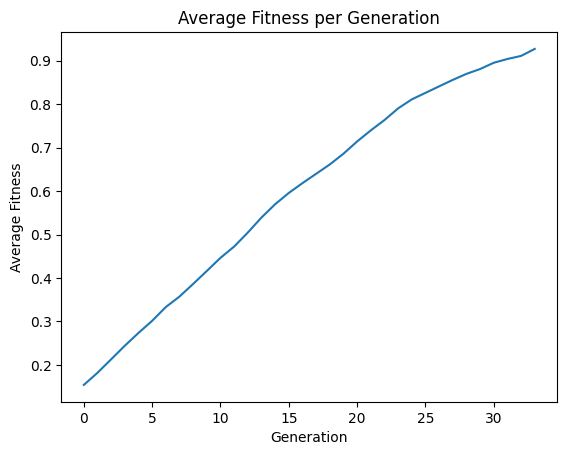

In [ ]:
# Run the main function
if __name__ == "__main__":
    main()